In [1]:
import sys
print(sys.executable)
print(sys.version)


C:\Users\gtvca\anaconda3\envs\tc_fase4\python.exe
3.12.12 | packaged by Anaconda, Inc. | (main, Oct 21 2025, 20:05:38) [MSC v.1929 64 bit (AMD64)]


In [3]:
pip install -U pip

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install tensorflow==2.15.* 

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement tensorflow==2.15.* (from versions: 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0, 2.19.1, 2.20.0rc0, 2.20.0)
ERROR: No matching distribution found for tensorflow==2.15.*


In [5]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

import pickle
import yaml
import os

# 2. Coleta dos dados

Neste notebook vamos usar o CSV já coletado via yfinance e filtrar apenas o ativo **ITUB4.SA**.

In [8]:
# Ajuste o caminho se necessário
csv_path = "dados_yfinance.csv"  # ou "dados_yfinance.csv" se estiver na mesma pasta

df_raw = pd.read_csv(csv_path)
df_raw["Data"] = pd.to_datetime(df_raw["Data"])
df_raw = df_raw.sort_values("Data").reset_index(drop=True)

ticker = "ITUB4.SA"
df = df_raw[df_raw["Ticker"] == ticker].copy()

# Mantemos apenas a coluna alvo (Fechamento) para manter o mesmo padrão do projeto referência (univariado)
df = df[["Data", "Fechamento"]].dropna().reset_index(drop=True)
df.rename(columns={"Fechamento":"Close"}, inplace=True)

df.head(), df.shape

    
# Cutoff para separar "desenvolvimento" e "dados recentes"
CUTOFF_DATE = "2025-09-01"

# Dev: dados anteriores ao cutoff (treino/val)
df_dev = df[df["Data"] < pd.Timestamp(CUTOFF_DATE)].copy().reset_index(drop=True)

# Recentes: dados a partir do cutoff (teste final)
df_recent = df[df["Data"] >= pd.Timestamp(CUTOFF_DATE)].copy().reset_index(drop=True)

df_dev.shape, df_recent.shape


((665, 2), (35, 2))

# 3. Exploração dos dados (EDA)

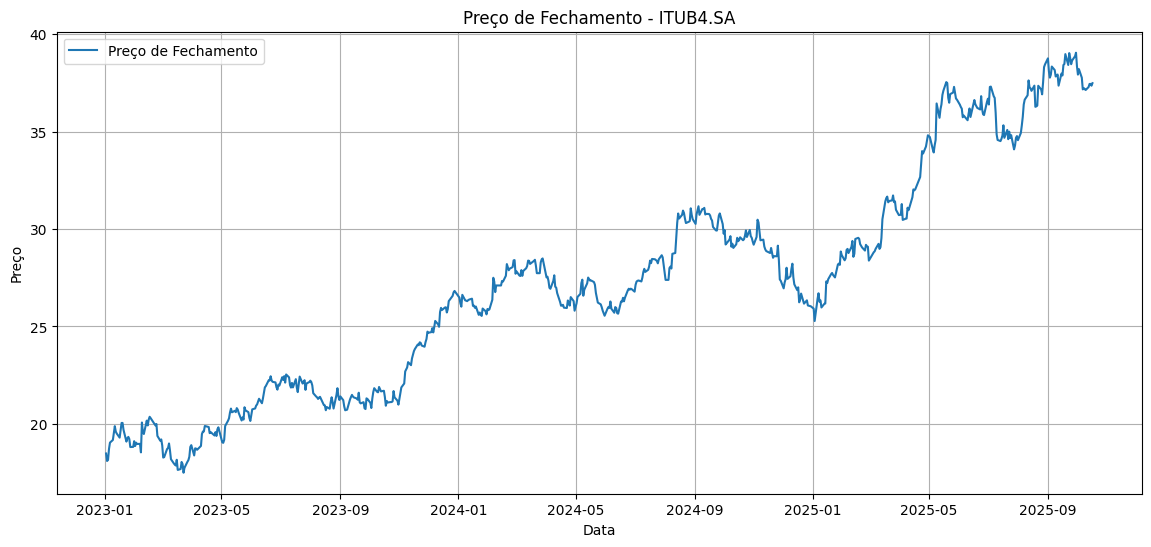

In [14]:
plt.figure(figsize=(14, 6))
plt.plot(df["Data"], df["Close"], label="Preço de Fechamento")
plt.title(f"Preço de Fechamento - {ticker}")
plt.xlabel("Data")
plt.ylabel("Preço")
plt.grid(True)
plt.legend()
plt.show()


#### 4. Preparação dos dados para o LSTM

Criação das janelas (window_size) para prever o próximo valor (horizon=1).

In [17]:
# 4. Normalização + Preparação de Sequências (somente no DEV)

# Fit do scaler somente no período de desenvolvimento (antes do cutoff)
scaler = MinMaxScaler()
scaled = scaler.fit(df_dev[["Close"]])
data_scaled = scaled.transform(df_dev[["Close"]])  # shape (N, 1)

def create_sequences(dataset, window_size):
    X, y = [], []
    for i in range(window_size, len(dataset)):
        X.append(dataset[i-window_size:i, 0])
        y.append(dataset[i, 0])
    return np.array(X), np.array(y)

window_size = 60
X, y = create_sequences(data_scaled, window_size)

# Formato (samples, timesteps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))
input_size = X.shape[-1]

X.shape, y.shape, input_size


((605, 60, 1), (605,), 1)

## 5.1 Separando treino e validação (80/20)

In [20]:
split = int(0.8 * X.shape[0])
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]

X_train.shape, X_val.shape, y_train.shape, y_val.shape


((484, 60, 1), (121, 60, 1), (484,), (121,))

# 6. Construção do Modelo LSTM

Epoch 1/150


C:\Users\gtvca\anaconda3\envs\tc_fase4\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 0.1399 - val_loss: 0.1778
Epoch 2/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0493 - val_loss: 0.0662
Epoch 3/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0433 - val_loss: 0.0419
Epoch 4/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0412 - val_loss: 0.0755
Epoch 5/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0405 - val_loss: 0.0522
Epoch 6/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0392 - val_loss: 0.0393
Epoch 7/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0427 - val_loss: 0.0473
Epoch 8/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0410 - val_loss: 0.0786
Epoch 9/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0394 - val_loss: 0.0624
Epoch 10/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0328 - val_loss: 0.0529
Epoch 11/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0326 - val_loss: 0.0408
Epoch 12/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0

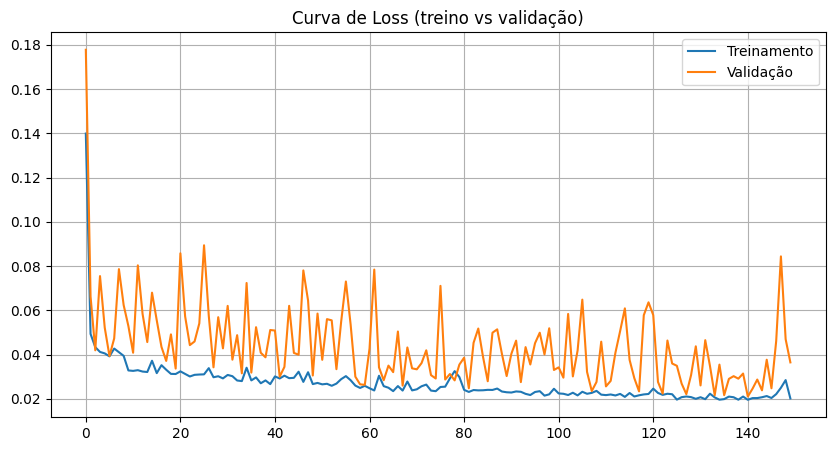

In [23]:
def train_model(window_size, input_size, neuronios, dropout, loss_function, epochs, batch_size):
    '''
    Essa função é destinada ao treinamento da LSTM.
    - window_size: tamanho da janela histórica
    - input_size: número de features por timestep
    - neuronios: unidades da LSTM
    - dropout: regularização
    - loss_function: função de perda
    - epochs, batch_size: hiperparâmetros de treino
    - return_sequences=True: necessário para empilhar 2 camadas LSTM
    - Dense(1): saída é o preço previsto
    '''
    model = Sequential([
        LSTM(neuronios, return_sequences=True, input_shape=(window_size, input_size)),
        Dropout(dropout),
        LSTM(neuronios),
        Dropout(dropout),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss=loss_function)

    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        verbose=1
    )

    # Curva de aprendizado (loss)
    plt.figure(figsize=(10, 5))
    plt.plot(history.history["loss"], label="Treinamento")
    plt.plot(history.history["val_loss"], label="Validação")
    plt.legend()
    plt.grid(True)
    plt.title("Curva de Loss (treino vs validação)")
    plt.show()

    return model

neuronios = 64
dropout = 0.2
loss_function = "mean_absolute_error"
epochs = 150
batch_size = 32

model = train_model(
    window_size=window_size,
    input_size=input_size,
    neuronios=neuronios,
    dropout=dropout,
    loss_function=loss_function,
    epochs=epochs,
    batch_size=batch_size
)


In [25]:
# Config (mesma ideia do projeto referência) + salvamento em YAML
config = {
    "ticker": ticker,
    "features": ["Close"],
    "path_scaler": "models/scaled.pkl",
    "treino": [{
        "window_size": window_size,
        "input_size": input_size,
        "neuronios": neuronios,
        "dropout": dropout,
        "loss_function": loss_function,
        "epochs": epochs,
        "batch_size": batch_size
    }]
}


# 7. Avaliação das previsões

In [28]:
# Previsões na validação (DEV)
y_pred = model.predict(X_val, verbose=0)

# Inverter escala (voltar para preço real)
y_pred_inv = scaler.inverse_transform(y_pred).reshape(-1)
y_val_inv = scaler.inverse_transform(y_val.reshape(-1, 1)).reshape(-1)

# Métricas (RAW)
mae_raw = mean_absolute_error(y_val_inv, y_pred_inv)
rmse_raw = np.sqrt(mean_squared_error(y_val_inv, y_pred_inv))
mape_raw = np.mean(np.abs((y_val_inv - y_pred_inv) / np.maximum(np.abs(y_val_inv), 1e-8))) * 100

# -------------------------------
# Correção por BIAS (OFFSET)
# BIAS estimado SOMENTE na validação (sem vazamento)
bias = float(np.mean(y_val_inv - y_pred_inv))

y_pred_inv_bias = y_pred_inv + bias

mae_bias = mean_absolute_error(y_val_inv, y_pred_inv_bias)
rmse_bias = np.sqrt(mean_squared_error(y_val_inv, y_pred_inv_bias))
mape_bias = np.mean(np.abs((y_val_inv - y_pred_inv_bias) / np.maximum(np.abs(y_val_inv), 1e-8))) * 100

print(f"VALIDAÇÃO (DEV) | RAW  -> MAE: {mae_raw:.4f} | RMSE: {rmse_raw:.4f} | MAPE: {mape_raw:.4f}%")
print(f"VALIDAÇÃO (DEV) | BIAS -> MAE: {mae_bias:.4f} | RMSE: {rmse_bias:.4f} | MAPE: {mape_bias:.4f}%")
print(f"BIAS (offset) estimado na validação: {bias:.6f}")

# Salvar métricas no config (mesma estrutura do notebook simples)
config.update({
    "cutoff_date": CUTOFF_DATE,
    "metricas_validacao": [{
        "bias": round(float(bias), 8),
        "mae_raw": round(float(mae_raw), 6),
        "rmse_raw": round(float(rmse_raw), 6),
        "mape_raw": round(float(mape_raw), 6),
        "mae_bias": round(float(mae_bias), 6),
        "rmse_bias": round(float(rmse_bias), 6),
        "mape_bias": round(float(mape_bias), 6),
    }]
})


VALIDAÇÃO (DEV) | RAW  -> MAE: 0.7645 | RMSE: 0.9120 | MAPE: 2.1669%
VALIDAÇÃO (DEV) | BIAS -> MAE: 0.4391 | RMSE: 0.5484 | MAPE: 1.2722%
BIAS (offset) estimado na validação: 0.728716


# 8. Visualizando previsão vs real

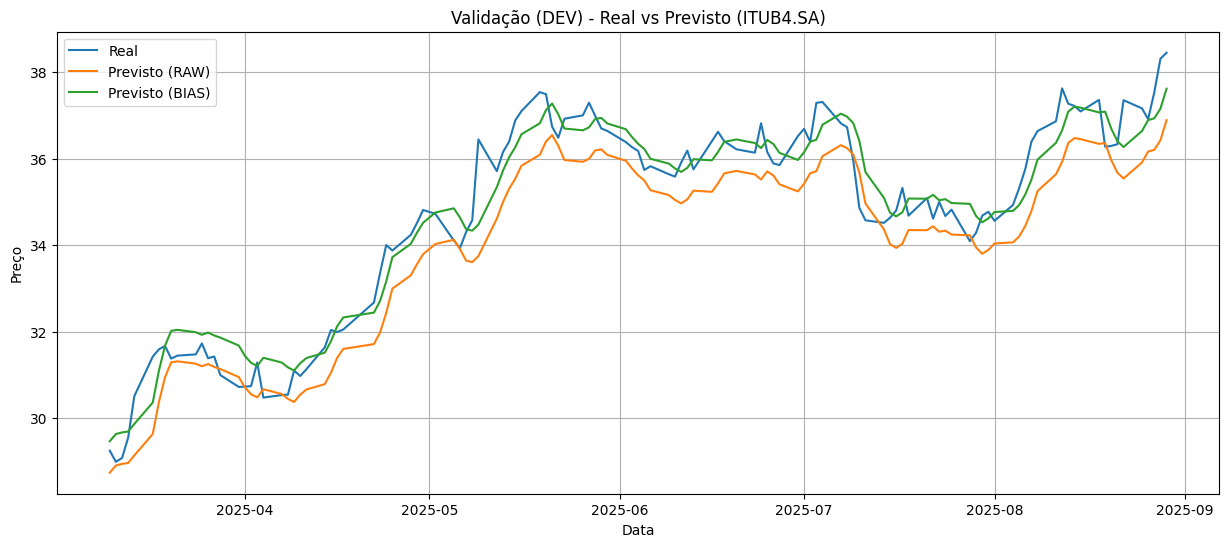

,Date,Close,Close_pred,Close_pred_bias
0,2025-03-10,29.240189,28.730139,29.458855
1,2025-03-11,28.982367,28.896952,29.625668
2,2025-03-12,29.071272,28.934473,29.663189
3,2025-03-13,29.542458,28.956182,29.684898
4,2025-03-14,30.502607,29.130032,29.858747


In [31]:
# Montando DataFrame com real vs previsto (validação - DEV)
val_start_idx = split + window_size  # índice do primeiro y de validação na série do DEV

df_val_pred = pd.DataFrame({
    "Date": df_dev["Data"].iloc[val_start_idx:].reset_index(drop=True),
    "Close": y_val_inv.reshape(-1),
    "Close_pred": y_pred_inv.reshape(-1),
    "Close_pred_bias": y_pred_inv_bias.reshape(-1),
})

plt.figure(figsize=(15, 6))
plt.plot(df_val_pred["Date"], df_val_pred["Close"], label="Real")
plt.plot(df_val_pred["Date"], df_val_pred["Close_pred"], label="Previsto (RAW)")
plt.plot(df_val_pred["Date"], df_val_pred["Close_pred_bias"], label="Previsto (BIAS)")
plt.title(f"Validação (DEV) - Real vs Previsto ({ticker})")
plt.xlabel("Data")
plt.ylabel("Preço")
plt.grid(True)
plt.legend()
plt.show()

df_val_pred.head()


# 9. Teste (dados recentes)

Aqui repetimos a ideia do notebook de referência: usar uma janela recente e medir métricas.

In [34]:
# 9. Teste (dados recentes a partir do cutoff) + aplicação do BIAS

df_recent.head(), df_recent.shape


(        Data      Close
 0 2025-09-01  38.762482
 1 2025-09-02  38.102779
 2 2025-09-03  37.772930
 3 2025-09-04  37.922859
 4 2025-09-05  38.342670,
 (35, 2))

TESTE (>= 2025-09-01) | RAW  -> MAE: 0.9318 | RMSE: 0.9999 | MAPE: 2.4418%
TESTE (>= 2025-09-01) | BIAS -> MAE: 0.3349 | RMSE: 0.4156 | MAPE: 0.8754%
BASELINE (persistência)  -> MAE: 0.2865 | RMSE: 0.3591 | MAPE: 0.7515%

Comparação (Seção 7 - Validação DEV):
VAL (DEV) RAW  -> MAE: 0.7645 | RMSE: 0.9120 | MAPE: 2.1669%
VAL (DEV) BIAS -> MAE: 0.4391 | RMSE: 0.5484 | MAPE: 1.2722%


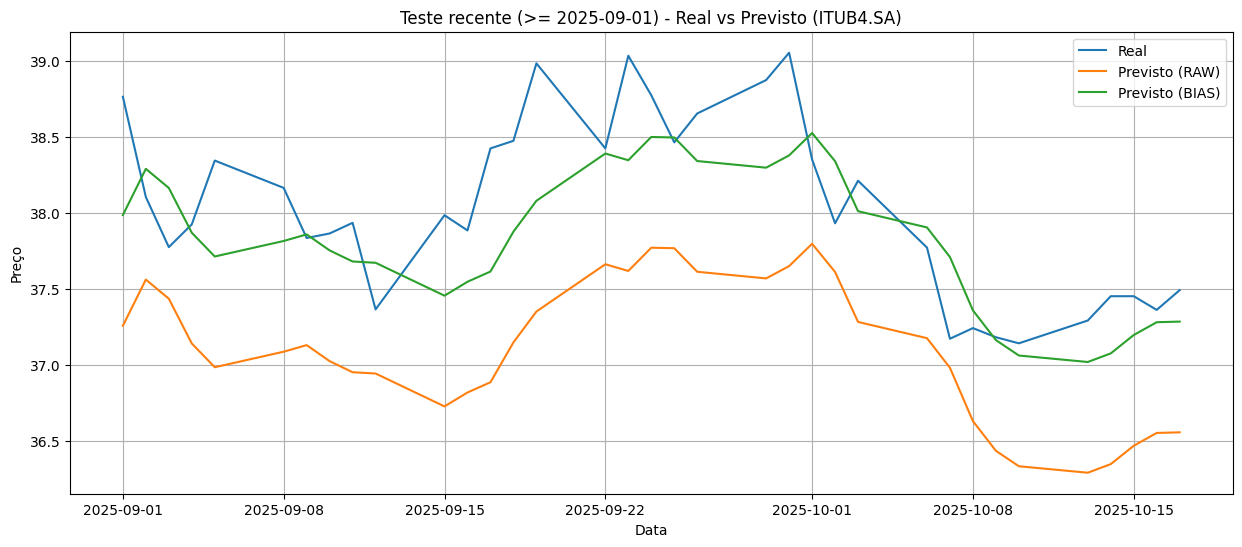

('predicoes_itub4_bias.csv',
         Date  Fechamento_Previsto
 0 2025-09-01            37.983932
 1 2025-09-02            38.288116
 2 2025-09-03            38.162338
 3 2025-09-04            37.867531
 4 2025-09-05            37.711361)

In [36]:
# Preparar janelas no período recente usando contexto do final do DEV
# (mantém a mesma lógica do create_sequences)

# Escalar dados recentes com o scaler treinado no DEV
recent_scaled = scaler.transform(df_recent[["Close"]]).astype(np.float32)  # shape (M,1)

# Contexto: última janela do DEV para conseguir prever o primeiro dia do recente
context = data_scaled[-window_size:]  # (window_size,1)

recent_full = np.vstack([context, recent_scaled])  # (window_size + M, 1)

X_test, y_test = create_sequences(recent_full, window_size)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Predição no recente
pred_test = model.predict(X_test, verbose=0)
pred_test_inv = scaler.inverse_transform(pred_test).reshape(-1)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1)).reshape(-1)

# Aplicar o MESMO bias (estimado na validação)
pred_test_inv_bias = pred_test_inv + bias

# Métricas no teste recente (RAW vs BIAS) + baseline persistência
mae_test_raw = mean_absolute_error(y_test_inv, pred_test_inv)
rmse_test_raw = np.sqrt(mean_squared_error(y_test_inv, pred_test_inv))
mape_test_raw = np.mean(np.abs((y_test_inv - pred_test_inv) / np.maximum(np.abs(y_test_inv), 1e-8))) * 100

mae_test_bias = mean_absolute_error(y_test_inv, pred_test_inv_bias)
rmse_test_bias = np.sqrt(mean_squared_error(y_test_inv, pred_test_inv_bias))
mape_test_bias = np.mean(np.abs((y_test_inv - pred_test_inv_bias) / np.maximum(np.abs(y_test_inv), 1e-8))) * 100

# Baseline: amanhã = hoje (persistência)
baseline = np.r_[y_test_inv[0], y_test_inv[:-1]]
mae_base = mean_absolute_error(y_test_inv, baseline)
rmse_base = np.sqrt(mean_squared_error(y_test_inv, baseline))
mape_base = np.mean(np.abs((y_test_inv - baseline) / np.maximum(np.abs(y_test_inv), 1e-8))) * 100

print(f"TESTE (>= {CUTOFF_DATE}) | RAW  -> MAE: {mae_test_raw:.4f} | RMSE: {rmse_test_raw:.4f} | MAPE: {mape_test_raw:.4f}%")
print(f"TESTE (>= {CUTOFF_DATE}) | BIAS -> MAE: {mae_test_bias:.4f} | RMSE: {rmse_test_bias:.4f} | MAPE: {mape_test_bias:.4f}%")
print(f"BASELINE (persistência)  -> MAE: {mae_base:.4f} | RMSE: {rmse_base:.4f} | MAPE: {mape_base:.4f}%")

# Comparação direta com a validação (Seção 7) — evidenciar ganho do BIAS
print("\nComparação (Seção 7 - Validação DEV):")
print(f"VAL (DEV) RAW  -> MAE: {mae_raw:.4f} | RMSE: {rmse_raw:.4f} | MAPE: {mape_raw:.4f}%")
print(f"VAL (DEV) BIAS -> MAE: {mae_bias:.4f} | RMSE: {rmse_bias:.4f} | MAPE: {mape_bias:.4f}%")

# DataFrame de previsões no recente
df_test_pred = pd.DataFrame({
    "Date": df_recent["Data"].reset_index(drop=True),
    "Close": y_test_inv.reshape(-1),
    "Close_pred": pred_test_inv.reshape(-1),
    "Close_pred_bias": pred_test_inv_bias.reshape(-1),
})

# Plot no período recente
plt.figure(figsize=(15,6))
plt.plot(df_test_pred["Date"], df_test_pred["Close"], label="Real")
plt.plot(df_test_pred["Date"], df_test_pred["Close_pred"], label="Previsto (RAW)")
plt.plot(df_test_pred["Date"], df_test_pred["Close_pred_bias"], label="Previsto (BIAS)")
plt.title(f"Teste recente (>= {CUTOFF_DATE}) - Real vs Previsto ({ticker})")
plt.xlabel("Data")
plt.ylabel("Preço")
plt.grid(True)
plt.legend()
plt.show()



In [69]:
# Previsões na validação (DEV)
y_pred = model.predict(X_val, verbose=0)

# Inverter escala (voltar para preço real)
y_pred_inv = scaler.inverse_transform(y_pred).reshape(-1)
y_val_inv = scaler.inverse_transform(y_val.reshape(-1, 1)).reshape(-1)

# Métricas (RAW)
mae_raw = mean_absolute_error(y_val_inv, y_pred_inv)
rmse_raw = np.sqrt(mean_squared_error(y_val_inv, y_pred_inv))
mape_raw = np.mean(np.abs((y_val_inv - y_pred_inv) / np.maximum(np.abs(y_val_inv), 1e-8))) * 100

# -------------------------------
# Correção por BIAS (OFFSET)
# BIAS estimado SOMENTE na validação (sem vazamento)
bias = float(np.mean(y_val_inv - y_pred_inv))

y_pred_inv_bias = y_pred_inv + bias

mae_bias = mean_absolute_error(y_val_inv, y_pred_inv_bias)
rmse_bias = np.sqrt(mean_squared_error(y_val_inv, y_pred_inv_bias))
mape_bias = np.mean(np.abs((y_val_inv - y_pred_inv_bias) / np.maximum(np.abs(y_val_inv), 1e-8))) * 100

print(f"VALIDAÇÃO (DEV) | RAW  -> MAE: {mae_raw:.4f} | RMSE: {rmse_raw:.4f} | MAPE: {mape_raw:.4f}%")
print(f"VALIDAÇÃO (DEV) | BIAS -> MAE: {mae_bias:.4f} | RMSE: {rmse_bias:.4f} | MAPE: {mape_bias:.4f}%")
print(f"BIAS (offset) estimado na validação: {bias:.6f}")

# Guardar no config (mesma ideia do seu notebook simples)
config.update({
    "cutoff_date": CUTOFF_DATE,
    "bias": round(float(bias), 8),
    "metricas_validacao_raw": {"mae": float(mae_raw), "rmse": float(rmse_raw), "mape": float(mape_raw)},
    "metricas_validacao_bias": {"mae": float(mae_bias), "rmse": float(rmse_bias), "mape": float(mape_bias)},
})


VALIDAÇÃO (DEV) | RAW  -> MAE: 0.7645 | RMSE: 0.9120 | MAPE: 2.1669%
VALIDAÇÃO (DEV) | BIAS -> MAE: 0.4391 | RMSE: 0.5484 | MAPE: 1.2722%
BIAS (offset) estimado na validação: 0.728716


Última data disponível: 2025-10-17 | último close: 37.4900016784668
Drift (mu): 0.0010122857733364547 | Volatilidade (sigma): 0.013121536323953246 | Dias projetados: 314


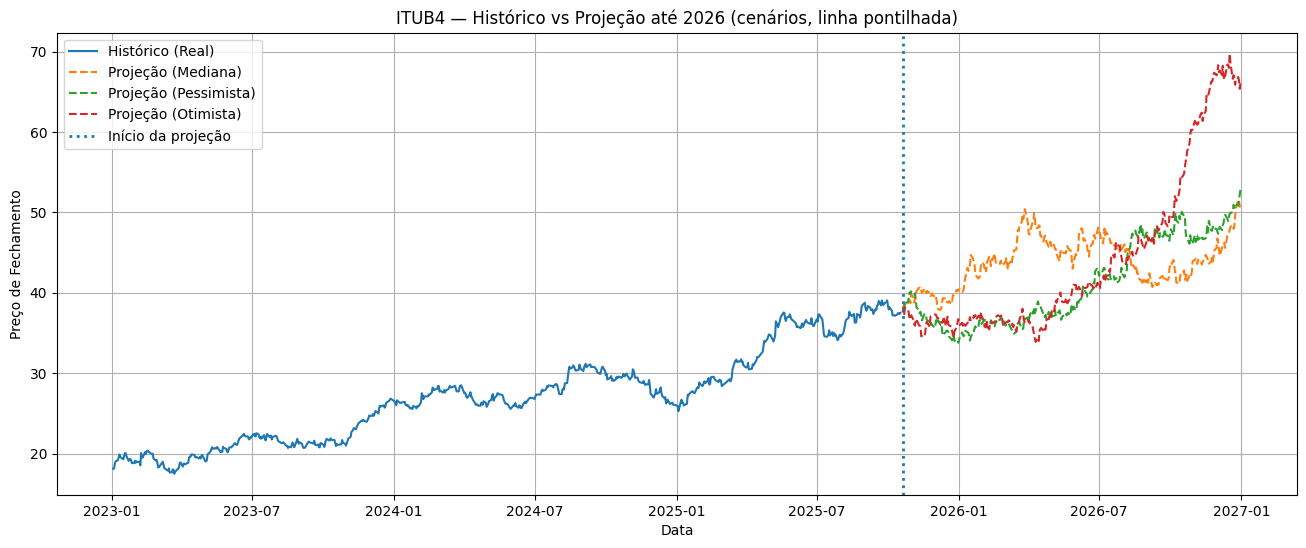

('projecao_itub4_cenarios_ate_2026.csv',
         Date  Pessimista    Mediana   Otimista
 0 2025-10-20   37.773365  38.176359  37.555422
 1 2025-10-21   37.743084  38.225558  38.137098
 2 2025-10-22   38.103770  38.608208  37.337272
 3 2025-10-23   38.912284  38.490290  38.132785
 4 2025-10-24   38.832201  38.693509  38.092346)

In [71]:
# 10. Projeção até 2026 (cenários) — log-retornos
# Para horizontes longos, uma projeção por cenários via log-retorno tende a ser mais estável do que
# previsão multi-step recursiva com LSTM (que acumula erro e "deriva").

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

FORECAST_END = pd.Timestamp("2026-12-31")

# Histórico completo (usa o df original do notebook)
df_all = df.copy().sort_values("Data").reset_index(drop=True)

# log-retornos históricos
df_all["logret"] = np.log(df_all["Close"]).diff()
df_all = df_all.dropna().reset_index(drop=True)

last_date = pd.to_datetime(df_all["Data"].iloc[-1])
last_price = float(df_all["Close"].iloc[-1])

# Dias úteis (aproximação: não considera feriados da B3)
future_dates = pd.bdate_range(start=last_date + pd.Timedelta(days=1), end=FORECAST_END)

# Parâmetros (drift e volatilidade) estimados do histórico
mu = float(df_all["logret"].mean())
sigma = float(df_all["logret"].std())

print("Última data disponível:", last_date.date(), "| último close:", last_price)
print("Drift (mu):", mu, "| Volatilidade (sigma):", sigma, "| Dias projetados:", len(future_dates))

# 3 trajetórias (pessimista/mediana/otimista) para visualização.
# Se quiser, gere 100+ trajetórias e calcule percentis.
np.random.seed(42)
n = len(future_dates)

eps = np.random.normal(0, 1, size=(3, n))
labels = ["Pessimista", "Mediana", "Otimista"]
paths = []

for k in range(3):
    r = mu + sigma * eps[k]
    price_path = last_price * np.exp(np.cumsum(r))
    paths.append(price_path)

df_fc_2026 = pd.DataFrame({
    "Date": future_dates,
    "Pessimista": paths[0],
    "Mediana": paths[1],
    "Otimista": paths[2],
})

# Gráfico: histórico vs cenários (linhas pontilhadas)
plt.figure(figsize=(16, 6))
plt.plot(df_all["Data"], df_all["Close"], label="Histórico (Real)")

plt.plot(df_fc_2026["Date"], df_fc_2026["Mediana"], linestyle="--", label="Projeção (Mediana)")
plt.plot(df_fc_2026["Date"], df_fc_2026["Pessimista"], linestyle="--", label="Projeção (Pessimista)")
plt.plot(df_fc_2026["Date"], df_fc_2026["Otimista"], linestyle="--", label="Projeção (Otimista)")

plt.axvline(df_fc_2026["Date"].min(), linestyle=":", linewidth=2, label="Início da projeção")

plt.title("ITUB4 — Histórico vs Projeção até 2026 (cenários, linha pontilhada)")
plt.xlabel("Data")
plt.ylabel("Preço de Fechamento")
plt.grid(True)
plt.legend()
plt.show()

# Export da projeção até 2026 (cenários)
OUT_PATH_2026 = "projecao_itub4_cenarios_ate_2026.csv"
df_fc_2026.to_csv(OUT_PATH_2026, index=False)

OUT_PATH_2026, df_fc_2026.head()